In [1]:
from pathlib import Path # reads paths in the current OS
import pandas as pd
import numpy as np
import json
import nltk
import matplotlib.pyplot as plt

from wordcloud import WordCloud
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
config = json.load(open('paths.cfg'))

data = pd.read_csv(Path(config['input_path']) / "abastiment_new.csv", sep=",").fillna('')

In [3]:
data.head()

PROJECTE URGENT  \
0                        3 Fermentats I Un Destí     Sí   
1                                      30 Cabres          
2                  7 de Ribera Hostal-Agrobotiga     Sí   
3                                       A Granel          
4  AgroMontserratí - Cooperativa del Montserratí          

                                         PRODUCTE(S)             MUNICIPI  \
0  pa massa mare natural kg vins naturals formatg...              torello   
1        formatges llet crua cabres pasturen pirineu  bellver de cerdanya   
2                          verdures produccio propia          mora d ebre   
3       cosmetica productes higiene neteja ecologics            barcelona   
4  fruita verdura transformats elaborats pinsos p...  olesa de montserrat   

                                         COM COMPRAR  \
0  repartim domicili osona resta catalunya consul...   
1  contacta telefon mail xarxes socials cabres mi...   
2  agrobotiga dijous divendres dijous tarde repar...   
3  venda directa punts recollida tota catalunya d...   
4  traves whatsap telefon xxxxxxxxx agrobotiga c ...   

                                        OBSERVACIONS CCPAE         COMARCA  \
0  il lusio colaborar oferir vos tres productes f...    Sí           Osona   
1  tots nostres formatges elaborats llet crua nos...              Cerdanya   
2                         www biosferacomestible cat         Ribera d’Ebre   
3                                                       Sí       Barcelona   
4                            www agromontserrati cat        Baix Llobregat   

      comarca_new                    locations  ... pickup shop market  phone  \
0           Osona  vic,solsona,osona,catalunya  ...      1    0      0      0   
1        Cerdanya                               ...      0    0      0      1   
2   Ribera d’Ebre                               ...      0    1      0      0   
3      Barcelones                    catalunya  ...      1    0      0      0   
4  Baix Llobregat                               ...      0    1      0      1   

   orders  whatsapp  socialnet  n_prod_princ  n_prod_others  n_prod_tot  
0       0         0          0             0              4           4  
1       0         0          1             0              2           2  
2       0         0          0             1              0           1  
3       0         0          0             1              2           3  
4       0         1          0             2              3           5  

[5 rows x 46 columns]

In [4]:
def show_wordcloud(data):
    text = " ".join(row for row in data)
    print ("There are {} words in the texts.".format(len(text)))
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

There are 40002 words in the texts.


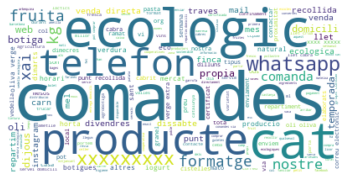

There are 14501 words in the texts.


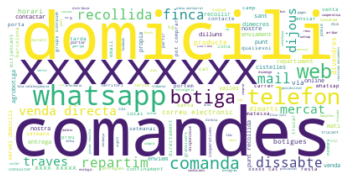

There are 14243 words in the texts.


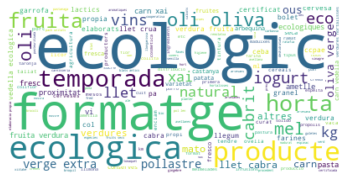

There are 11708 words in the texts.


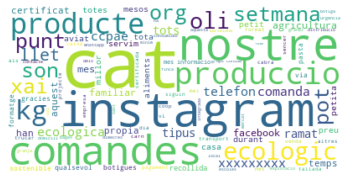

In [5]:
show_wordcloud(data['COM COMPRAR'] + data['PRODUCTE(S)'] + data['OBSERVACIONS'])
show_wordcloud(data['COM COMPRAR'])
show_wordcloud(data['PRODUCTE(S)'])
show_wordcloud(data['OBSERVACIONS'])

In [6]:
tvec = TfidfVectorizer(min_df=.0025, max_df=.1, ngram_range=[1,2])
tvec_weights = tvec.fit_transform(data['COM COMPRAR'] + data['PRODUCTE(S)'] + data['OBSERVACIONS'])
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)
# even the largest weights are pretty low, it doesn't appear 
# to be a text different from the rest

term    weight
5928            verdura  0.016230
6222                xai  0.016172
3288               llet  0.014269
5495          temporada  0.011733
1688            directa  0.011681
5932  verdura ecologica  0.011501
4046              oliva  0.011470
4021                oli  0.011465
546              botiga  0.010877
5891      venda directa  0.010769
2011          ecologics  0.010644
4652             propia  0.010085
2945              horta  0.009826
4939           repartim  0.009160
2480              finca  0.009114
3127                 kg  0.009040
5856            vedella  0.008937
162              altres  0.008918
635               cabra  0.008860
1413             correu  0.008715

## Word2vec + Umap test

In [7]:
from gensim.models import KeyedVectors
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
import plotly
import plotly.graph_objs as go
import umap.umap_ as umap

/Users/work/.virtualenvs/dadess/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [8]:
model = KeyedVectors.load_word2vec_format(Path(config['input_path'])/ 'w2v_cat_model.bin',binary=True)

In [9]:
# Tokenize the string into words
tokens = word_tokenize(' '.join(data['PRODUCTE(S)'].values))

# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in tokens if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in tokens if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')

# add a column with the word category and another with a 
# number in order to plot it in a different color afterwards
product_cat = json.load(open('product_list.cfg'))

df['cat'] ='none'
for key, val in product_cat.items():
    df.loc[df.index.isin(val),'cat'] = key

In [10]:
reducer = umap.UMAP(metric='cosine', n_neighbors=15, min_dist=0.05, random_state=42)
embedding = reducer.fit_transform(df.iloc[:,0:99])

d = pd.DataFrame(embedding, columns=['c1', 'c2'])
d['word'] = [w for w in df.index]
d['cat'] = [cat for cat in df.cat]

fig = go.Figure()

col=["#003f5c", "#665191", "#d45087", "#f95d6a", "#ff7c43",
     "#ffa600", '#28590C', '#ff6174', '#d6c5b5', '#693d3d',
     '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
     '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
     '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
     '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

for i, val in enumerate(df.cat.unique()):
    fig.add_trace(go.Scattergl(
        x = d[d.cat==val].c1,
        y = d[d.cat==val].c2,
        name = val,
        mode = 'markers',
        marker = dict(
            color = col[i],
            colorscale='Viridis',
            size = 6,
            opacity=0.75
        ),
        text='Paraula: '+d[d.cat==val].word
    ))

fig.update_layout(title = "Word2Vec pels productes" ,
              paper_bgcolor='rgba(0,0,0,0)',
              plot_bgcolor='rgba(0,0,0,0)',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              hovermode = 'closest',
              showlegend=True
             )

fig.show()
# Will open in browser and save the file offline:
# chart = plotly.offline.plot(fig, filename='plot')

Meat, fruit and vegetables seem to be grouping together. There are also some interesting clusters:
- for colors and some shapes
- for metrics (kg, ml...)
- for spanish words
- for locations
- for packages (bossa, caixes...)
More synonims could be extracted from this representation (based on closeness to other words).
The plot could be improved with a better pre-processing (stemming, removing "irrelevant" words...)

### Visualizing 'COM COMPRAR' column:

In [11]:
sum(data.delivery.fillna(0))

95

In [12]:
data.delivery

0      1
1      0
2      1
3      1
4      0
      ..
221    0
222    0
223    0
224    1
225    1
Name: delivery, Length: 226, dtype: int64

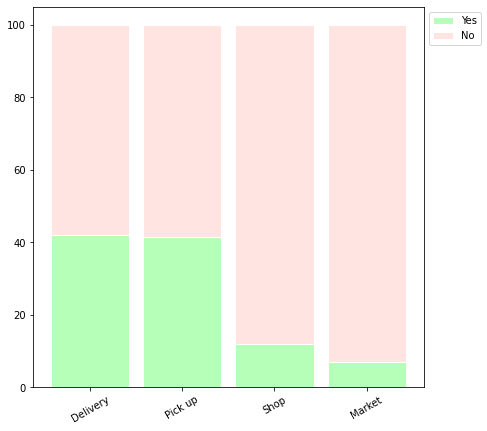

In [13]:
## For this plot see pag: https://python-graph-gallery.com/13-percent-stacked-barplot/
   
import matplotlib.pyplot as plt
    
dim=data.shape[0]


# Data
r = [0,1,2,3]
raw_data = {'yes': [sum(data.delivery), sum(data.pickup), sum(data.shop), sum(data.market)], \
            'no': [dim-sum(data.delivery), dim-sum(data.pickup), dim-sum(data.shop), dim-sum(data.market)]}
df = pd.DataFrame(raw_data)
 
df.head()

df['suma']=df.yes+df.no

df.head()

# From raw value to percentage
totals = [i+j for i,j in zip(df['yes'], df['no'])]
greenBars = [i / j * 100 for i,j in zip(df['yes'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['no'], totals)]
#blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]
 


# plot
plt.figure(figsize=(7,7))
barWidth = 0.85
names = ('Delivery','Pick up','Shop','Market')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label='Yes')
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='mistyrose', edgecolor='white', width=barWidth, label='No')
## Create blue Bars
#plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, names, rotation=30)
plt.xlabel("")
 
 
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 
# Show graphic
plt.show()

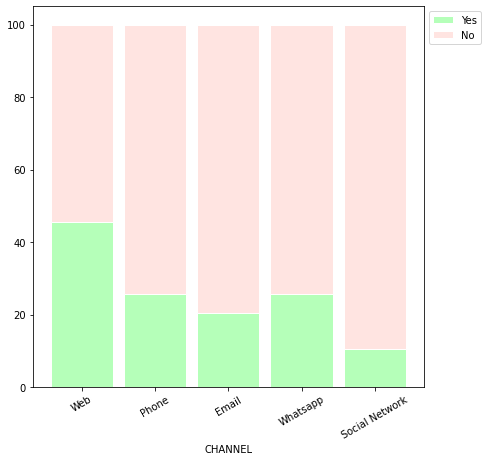

In [14]:
##-- Communication channels

r = [0,1,2,3,4]
raw_data = {'yes': [sum(data.web), sum(data.phone), sum(data.mail), \
                    sum(data.whatsapp), sum(data.socialnet)],\
            'no': [dim-sum(data.web), dim-sum(data.phone), dim-sum(data.mail),\
                   dim-sum(data.whatsapp), dim-sum(data.socialnet) ]}
df = pd.DataFrame(raw_data)
 
df.head()

df['suma']=df.yes+df.no

df.head()

# From raw value to percentage
totals = [i+j for i,j in zip(df['yes'], df['no'])]
greenBars = [i / j * 100 for i,j in zip(df['yes'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['no'], totals)]
#blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]
 


# plot
plt.figure(figsize=(7,7))
barWidth = 0.85
names = ('Web', 'Phone', 'Email', 'Whatsapp', 'Social Network')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label='Yes')
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='mistyrose', edgecolor='white', width=barWidth, label='No')
## Create blue Bars
#plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, names, rotation=30)
plt.xlabel("CHANNEL")
 
 
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 
# Show graphic
plt.show()

### Visualizing 'PRODUCTE(S)' column:

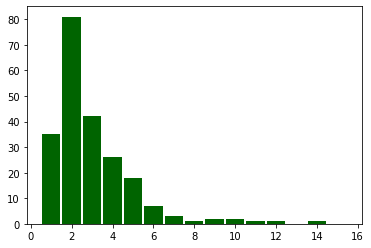

In [15]:
plt.hist(data['n_prod_tot'], 
         bins= np.arange(0.5, 16.5, 1.0), 
         rwidth=0.9, 
         color='darkgreen')
plt.show()
#np.arange(-0.5, 20.5, 1.0)


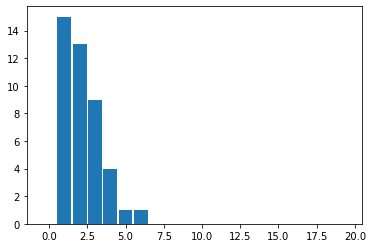

In [16]:
plt.hist(data.loc[(data.n_prod_princ==0) & (data.n_prod_tot>0), 'n_prod_others'],
         bins=np.arange(-0.5, 20.5, 1.0), 
         rwidth=0.9)
plt.show()

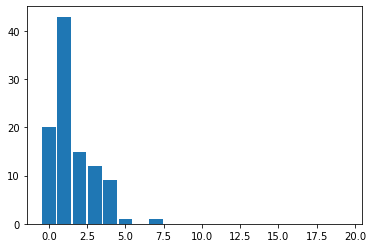

In [17]:
plt.hist(data.loc[data.n_prod_princ==1, 'n_prod_others'],
         bins=np.arange(-0.5, 20.5, 1.0), 
         rwidth=0.9)
plt.show()
## Los que venden 1 producto principal, generalmente no venden otros (54) o venden 1-2 otros (27-8)

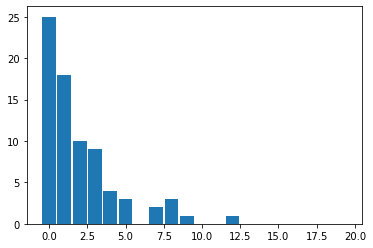

In [18]:
## Entre los que venden 2 o 3 productos principales, hay 27 que no venden otras cosas, pero 19 que sí 
## venden otros productos
## aquí no está bien definido como era en pagesos..

plt.hist(data.loc[data.n_prod_princ>=2, 'n_prod_others'],
         bins=np.arange(-0.5, 20.5, 1.0), 
         rwidth=0.9)
plt.show()

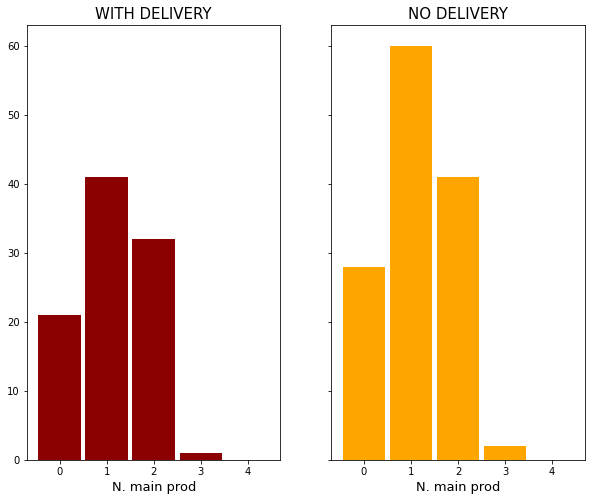

In [19]:
(fig, (ax1, ax2)) = plt.subplots(1, 2, sharey=True, figsize=(10,8))
#ax1.hist(df['normal'], bins=100)

ax1.hist(data[data['delivery']>0].n_prod_princ, 
         bins=np.arange(-0.5,5.5,1), 
         rwidth=0.9, 
         color='darkred')
ax1.set_title('WITH DELIVERY', fontsize=15)
ax1.set_xlabel('N. main prod', fontsize=13)

#ax2.hist(df['random'], bins=100)
ax2.hist(data[data['delivery']==0].n_prod_princ, 
         bins=np.arange(-0.5,5.5,1), 
         rwidth=0.9, 
         color='orange')
ax2.set_title('NO DELIVERY', fontsize=15)
ax2.set_xlabel('N. main prod', fontsize=13)
plt.show()

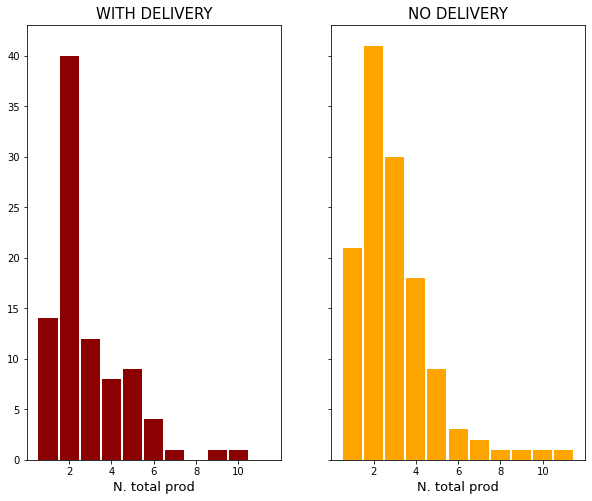

In [20]:
#f = plt.figure(figsize=(10,8))
#ax1 = f.add_subplot(121)
#ax2 = f.add_subplot(122)

(fig, (ax1, ax2)) = plt.subplots(1, 2, sharey=True, figsize=(10,8))
#ax1.hist(df['normal'], bins=100)

ax1.hist(data[(data['delivery']>0) & (data.n_prod_tot>0)].n_prod_tot, 
         bins=np.arange(0.5, 12.5, 1), 
         rwidth=0.9, 
         color='darkred')
ax1.set_title('WITH DELIVERY', fontsize=15)
ax1.set_xlabel('N. total prod', fontsize=13)

#ax2.hist(df['random'], bins=100)
ax2.hist(data[(data['delivery']==0 ) & (data.n_prod_tot>0)].n_prod_tot, 
         bins=np.arange(0.5, 12.5,1), 
         rwidth=0.9, 
         color='orange')
ax2.set_title('NO DELIVERY', fontsize=15)
ax2.set_xlabel('N. total prod', fontsize=13)
plt.show()

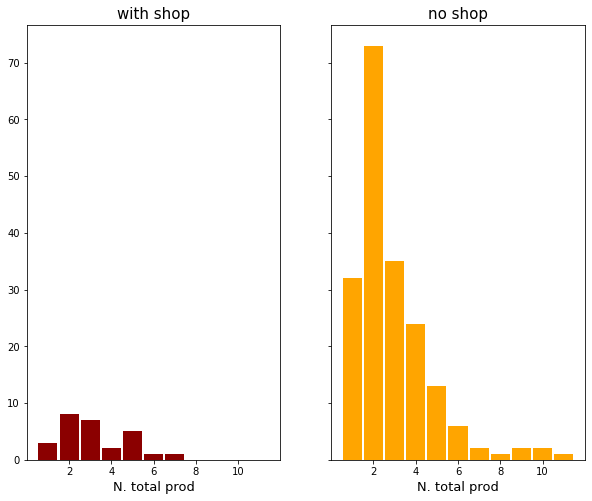

In [21]:

#f = plt.figure(figsize=(10,8))
#ax1 = f.add_subplot(121)
#ax2 = f.add_subplot(122)

(fig, (ax1, ax2)) = plt.subplots(1, 2, sharey=True, figsize=(10,8))
#ax1.hist(df['normal'], bins=100)

ax1.hist(data[(data['shop']>0) & (data.n_prod_tot>0)].n_prod_tot, 
         bins=np.arange(0.5, 12.5, 1), 
         rwidth=0.9, 
         color='darkred')
ax1.set_title('with shop', fontsize=15)
ax1.set_xlabel('N. total prod', fontsize=13)

#ax2.hist(df['random'], bins=100)
ax2.hist(data[(data['shop']==0 ) & (data.n_prod_tot>0)].n_prod_tot, 
         bins=np.arange(0.5, 12.5,1), 
         rwidth=0.9, 
         color='orange')
ax2.set_title('no shop', fontsize=15)
ax2.set_xlabel('N. total prod', fontsize=13)
plt.show()

### Comarcas analysis

In [22]:
print(data.groupby(['COMARCA']).agg({'PROJECTE': ['count']}),
      '\n',
      data.groupby('COMARCA').size()
     )

                                                   PROJECTE
                                                      count
COMARCA                                                    
Al Urgell                                                 1
Alt Camp                                                 10
Alt Empordà                                               8
Alt Maresme                                               1
Alt Penedès                                               5
Alt Urgell                                                4
Alta Ribagorça                                            1
Anoia                                                     7
Bages                                                     8
Bages-Moianès                                             1
Baix Camp                                                 7
Baix Ebre                                                 6
Baix Empordà                                              7
Baix Llobregat                          

In [23]:
print(data.groupby(['comarca_new'])['PROJECTE'].count().sort_values(ascending=False),
      '\n',
      data.groupby(['comarca_new'])['URGENT'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
     )


comarca_new
Valles Oriental                                       24
Maresme                                               14
Baix Llobregat                                        12
Alt Camp                                              10
Osona                                                  9
Barcelones                                             8
Alt Emporda                                            8
Bages                                                  8
Baix Emporda                                           7
Cerdanya                                               7
Bergueda                                               7
Anoia                                                  7
Baix Camp                                              7
Valles Occidental                                      6
Terra Alta                                             6
Baix Ebre                                              6
Tarragones                                             6
Ripolles           